# Common Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy
import sklearn
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports

In [2]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, LocalOutlierFactor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


# Set The Visual Style

In [3]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

# Set Hyperparameters

In [4]:
new_apt_sample_size = 3
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 3
random_seed = 42
var_threshold = 0.3
test_size = 0.3
preferred_score = 'r2'
tensorflow.set_random_seed(random_seed)

# Import Data
## Main Dataset

In [5]:
query_dir = 'queries'

In [6]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [7]:
query_client = bigquery.Client()

In [8]:
request = queries['combined_analysis_data.sql']

In [9]:
data = query_client.query(request).to_dataframe()

In [10]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 5453
Data columns (total 22 columns):
ad_id                 4847 non-null int64
apt_id                3562 non-null object
new_building          4847 non-null bool
num_bedrooms          4776 non-null float64
floor                 4066 non-null float64
primary_size          4847 non-null float64
total_size            4739 non-null float64
price                 4847 non-null float64
property_type         4847 non-null object
ownership_type        4847 non-null object
construction_year     4842 non-null float64
energy_character      1657 non-null object
common_expenses       968 non-null float64
brokerage_expenses    1282 non-null float64
common_wealth         679 non-null float64
common_debt           1212 non-null float64
time_s                4674 non-null float64
lat                   4674 non-null float64
lng                   4674 non-null float64
address               4847 non-null object
short_description     484

## Google Maps Neighborhood Data

In [12]:
request = queries['all_post_code_places.sql']

In [13]:
gmaps_neighborhood_data = query_client.query(request).to_dataframe()

In [14]:
gmaps_neighborhood_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117498 entries, 0 to 117497
Data columns (total 6 columns):
post_code          117498 non-null object
radius             117498 non-null int64
place_name         117498 non-null object
place_type         117498 non-null object
place_attribute    117498 non-null object
attribute_value    42240 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.4+ MB


## Norwegian Post Code Data

In [15]:
request = queries['post_codes_osl.sql']
post_codes_osl = query_client.query(request).to_dataframe().set_index('post_code', drop=True)

In [16]:
request = queries['post_codes_no.sql']
post_codes_no = query_client.query(request).to_dataframe().set_index('post_code', drop=True)

# Feature Engineering
## Energy Letter and Color

In [17]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

## Post Codes

In [18]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [19]:
data['post_code'] = data.address.apply(get_postcode_from_address)

## Combined Area Names

In [20]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['municipality']

In [21]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

In [22]:
data['area_name'] = [s_n.lower() if s_n != 'oslo' else n_n.lower() for s_n, n_n in zip(data['settlement_name'], data['neighborhood_name'])]

In [23]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'oslo' else False)

## Price Per Square Meter

In [24]:
data['price_per_sq_m'] = data.price.div(data.primary_size).round(0)

In [25]:
new_building_pct = pd.Series(data[data.new_building == True]\
                             .groupby('area_name')['ad_id'].count()\
                             .div(data\
                                  .groupby('area_name')['ad_id'].count()),
                             name='area_new_building_pct')

data = data.merge(new_building_pct, how='left', left_on='area_name', right_index=True)

## Combined Property Type

In [26]:
data['comb_property_type'] = ['house' if pt in ['Enebolig', 'Rekkehus', 'Tomannsbolig']
                              else 'apartment' if pt == 'Leilighet'
                              else 'other'
                              for pt in data['property_type']]

## Median House Price Per Post Code

In [27]:
median_property_prices = pd.pivot_table(data=data[data.comb_property_type.isin(['house', 'apartment'])],
                                        index='post_code',
                                        columns='comb_property_type',
                                        values='price_per_sq_m',
                                        aggfunc='median')

median_property_prices.rename(columns={'apartment': 'med_price_apartment', 'house': 'med_price_house'}, inplace=True)

data = data.merge(median_property_prices, how='left', left_on='post_code', right_index=True)

# Data Imputation

In [172]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

common_wealth            4164
common_expenses          3878
common_debt              3631
brokerage_expenses       3565
energy_character         3187
med_price_house          1918
apt_id                   1281
med_price_apartment       179
lng                       173
lat                       173
area_new_building_pct      67
immigrant_pct               4
cramped_spaces              4
income_inequality           4
uni_graduates               4
low_income_households       4
establishment               1
convenience_store           1
courthouse                  1
dentist                     1
dtype: int64

## Impute Number Of Bedrooms

In [29]:
data['primary_size_bin'] = pd.cut(data['primary_size'], bins=[-np.inf, 30, 40, 50, 60, 70, 80, 100, 150, 200, np.inf])

In [30]:
num_bedrooms_grouping = data.groupby(['primary_size_bin'])['num_bedrooms'].median()

In [31]:
data['num_bedrooms'] = [num_bedrooms_grouping.loc[size_bin] if np.isnan(num_bedr) else num_bedr
                        for size_bin, num_bedr
                        in zip(data['primary_size_bin'], data['num_bedrooms'])]

## Impute Floor

In [32]:
data['floor_level'] = [fl if prop_type == 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]
data['num_floors'] = [fl if prop_type != 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]

data['floor_level'] = data['floor_level'].fillna(1)
data['num_floors'] = data['num_floors'].fillna(1)
data['floor'] = data['floor'].fillna(2)

## Impute Total Size

In [33]:
data['total_size'] = [primary_size if np.isnan(total_size) else total_size
                      for primary_size, total_size
                      in zip(data['primary_size'], data['total_size'])]

## Impute Construction Year

In [34]:
data['construction_year'].fillna(data[data['new_building'] == False]['construction_year'].median(), inplace=True) 

## Impute Energy Character

In [35]:
constr_year_bins = [-np.inf, 1900, 1945, 1965, 1970, 1980, 1990, 2000, 2010, np.inf]
data['construction_year_bin'] = pd.cut(data['construction_year'],
                                       bins=constr_year_bins)

In [36]:
to_plot = data.groupby(['construction_year_bin', 'energy_letter'])['energy_letter'].count()

In [37]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [38]:
energy_letter_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [39]:
def imnpute_energy_letter(letter, construction_year_bin):
    if str(letter) in 'ABCDEFG':
        return letter
    else:
        return energy_letter_grouping.loc[construction_year_bin]

In [40]:
data['energy_letter'] = [imnpute_energy_letter(letter, construction_year_bin) for letter, construction_year_bin in zip(data['energy_letter'], data['construction_year_bin'])]

In [41]:
to_plot = data.groupby(['construction_year_bin', 'energy_color'])['energy_color'].count()

In [42]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [43]:
energy_color_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [44]:
def imnpute_energy_color(color, construction_year_bin):
    if str(color) in ['mørkegrønn', 'oransje', 'lysegrønn', 'rød', 'gul']:
        return color
    else:
        return energy_color_grouping.loc[construction_year_bin]

In [45]:
data['energy_color'] = [imnpute_energy_color(color, construction_year_bin) for color, construction_year_bin in zip(data['energy_color'], data['construction_year_bin'])]

## Impute Travel Time

In [46]:
missing_transport_factor = 1
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)

# Google Maps Data

In [47]:
gmaps_neighborhood_data.head()

,post_code,radius,place_name,place_type,place_attribute,attribute_value
0,0001,500,Oslo,locality,rating,NaN
1,0001,500,Oslo,political,rating,NaN
2,0001,500,Oslo Opera House,premise,rating,NaN
3,0001,500,Oslo Opera House,point_of_interest,rating,NaN
4,0001,500,Oslo Opera House,establishment,rating,NaN


In [48]:
neighborhood_data = pd.DataFrame(index=gmaps_neighborhood_data.post_code.unique())

In [49]:
neighborhood_data['mean_post_code_rating'] = gmaps_neighborhood_data[(gmaps_neighborhood_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].mean()

In [50]:
neighborhood_data['post_code_place_count'] = gmaps_neighborhood_data[(gmaps_neighborhood_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].count()

In [51]:
to_plot = gmaps_neighborhood_data[gmaps_neighborhood_data.place_attribute == 'rating']
place_counts = pd.pivot_table(data=to_plot, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)

In [52]:
neighborhood_data = neighborhood_data.join(place_counts)

In [53]:
neighborhood_data.fillna(0, inplace=True)

In [54]:
data = data.merge(neighborhood_data, how='left', left_on='post_code', right_index=True)

In [55]:
neighborhood_cols = list(neighborhood_data.columns)

# National Health Institute Data

In [56]:
request = queries['full_fhi_data.sql']

In [57]:
fhi_data = query_client.query(request).to_dataframe()

In [58]:
fhi_data.head()

,dataset,area_name,year,value
0,income_inequality,hurdal,2013,0.023
1,income_inequality,st.hanshaugen,2013,0.038
2,income_inequality,frogner,2013,0.045
3,income_inequality,ullern,2013,0.039
4,income_inequality,vestre aker,2013,0.043


In [59]:
fhi_data_latest = pd.DataFrame(index=fhi_data.area_name.unique())
for dataset in fhi_data.dataset.unique():
    to_join = fhi_data[fhi_data.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    fhi_data_latest = fhi_data_latest.join(to_join_pivot)

In [60]:
fhi_data_latest.head()

,income_inequality,uni_graduates,low_income_households,cramped_spaces,immigrant_pct
hurdal,0.025,0.35,0.168,0.128,0.103
st.hanshaugen,0.038,0.73,0.186,0.469,0.278
frogner,0.047,0.72,0.160,0.328,0.280
ullern,0.040,0.76,0.066,0.160,0.199
vestre aker,0.045,0.77,0.069,0.140,0.178


In [61]:
fhi_cols = list(fhi_data_latest.columns)

In [62]:
data = data.merge(fhi_data_latest, how='left', left_on='area_name', right_index=True)

# Remove Properties Other Than Houses and Apartments

In [63]:
data = data[~data.property_type.isin(['Garasje/Parkering', 'Gårdsbruk/Småbruk'])].copy()

# Mark Selected Columns

In [64]:
num_cols = ['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor', 'num_bedrooms',
            'construction_year', 'area_new_building_pct', 'med_price_apartment', 'med_price_house'] + fhi_cols + neighborhood_cols
cat_cols = ['comb_property_type', 'ownership_type', 'address_oslo', 'new_building']
text_cols = ['full_description']

In [65]:
data_sample_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(n=new_apt_sample_size, random_state=random_seed)
                                                             if len(obj) > new_apt_sample_size
                                                             else obj.sample(len(obj)))

In [66]:
num_data = data_sample_from_new_buildings[num_cols].copy()

In [67]:
cat_data = data_sample_from_new_buildings[cat_cols].copy()

In [68]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [69]:
text_data = data_sample_from_new_buildings[text_cols].copy()

# Predict Price With Numeric And Categorical Features

In [70]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data

In [71]:
def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val

In [72]:
def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [73]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [74]:
estimators = {'deep_learning_regressor': KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False),
              'adaboost': AdaBoostRegressor(random_state=random_seed),
              'linear': LinearRegression(),
              'kneighbors': KNeighborsRegressor(),
              'bayes': ComplementNB(),
              'mlp': MLPRegressor(random_state=random_seed)}

In [75]:
estimator = estimators['adaboost']

# Define Model Data
## Remove NaNs

In [76]:
model_data = num_data.join(cat_data)

In [77]:
model_data.dropna(inplace=True)

## Select Properties In Oslo

In [78]:
# model_data = model_data[model_data.address_oslo_True == 1].copy()
# model_data.drop('address_oslo_True', axis=1, inplace=True)

In [79]:
model_data.shape

(990, 126)

## Remove Low Variance Features

In [80]:
var_estimator = VarianceThreshold(threshold=var_threshold)

In [81]:
var_estimator.fit(model_data)

VarianceThreshold(threshold=0.3)

In [82]:
variances = pd.Series(var_estimator.variances_, index=model_data.columns)

In [83]:
variances.sort_values(ascending=False).head(30)

price                       1.055922e+13
price_per_sq_m              3.951675e+08
med_price_apartment         3.012279e+08
med_price_house             2.847710e+08
time_s                      5.987908e+06
primary_size                2.904501e+03
construction_year           6.412263e+02
post_code_place_count       2.560633e+01
establishment               1.914707e+01
point_of_interest           1.914707e+01
store                       7.881242e+00
health                      2.232120e+00
home_goods_store            1.484205e+00
food                        1.461652e+00
floor                       1.445372e+00
num_bedrooms                1.234985e+00
mean_post_code_rating       1.056806e+00
grocery_or_supermarket      6.903540e-01
school                      5.724355e-01
restaurant                  4.968768e-01
furniture_store             4.250342e-01
car_repair                  4.218916e-01
clothing_store              4.033058e-01
electronics_store           4.004336e-01
hair_care       

In [84]:
variance_filtered_features = pd.Series(var_estimator.get_support(), index=model_data.columns)

In [85]:
variance_selected_features = list(variance_filtered_features[variance_filtered_features == True].index)

In [86]:
model_data = model_data[variance_selected_features].copy()

## List All Columns

In [87]:
model_data.columns

Index(['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor',
       'num_bedrooms', 'construction_year', 'med_price_apartment',
       'med_price_house', 'mean_post_code_rating', 'post_code_place_count',
       'car_repair', 'clothing_store', 'electronics_store', 'establishment',
       'finance', 'food', 'furniture_store', 'grocery_or_supermarket',
       'hair_care', 'health', 'home_goods_store', 'point_of_interest',
       'restaurant', 'school', 'store'],
      dtype='object')

## Remove Outliers

In [88]:
outlier_detector = LocalOutlierFactor()

In [89]:
outlier_detector.fit(model_data)

/Users/ruslan.kozhuharov/venvs/home_oslo_home/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=False, p=2)

In [90]:
model_data['neg_outlier_factor'] = outlier_detector.negative_outlier_factor_

In [91]:
model_data = model_data[model_data.neg_outlier_factor > -1.5].copy()

In [92]:
model_data.drop('neg_outlier_factor', axis=1, inplace=True)

## Select Modelling Target

In [93]:
target = 'price_per_sq_m'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [94]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [95]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

## Define X and y

In [96]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [97]:
X.shape

(966, 24)

In [98]:
x_cols = X.columns

## Perform Train-Test Split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [100]:
X_train.shape

(676, 24)

In [101]:
X_sparse = scipy.sparse.csr_matrix(X.values)

## Define Pipeline

In [102]:
steps = []

# steps.append(('scale', MaxAbsScaler()))
steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('pca', PCA(n_components=10)))
# steps.append(('standardize', StandardScaler()))
steps.append(('estimator', estimator))

In [103]:
pipeline = Pipeline(steps)

# Perform Recursive Feature Elimination

In [104]:
rfe = RFECV(estimator, step=1, cv=KFold(cv), scoring='neg_median_absolute_error')

In [105]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                  loss='linear', n_estimators=50,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

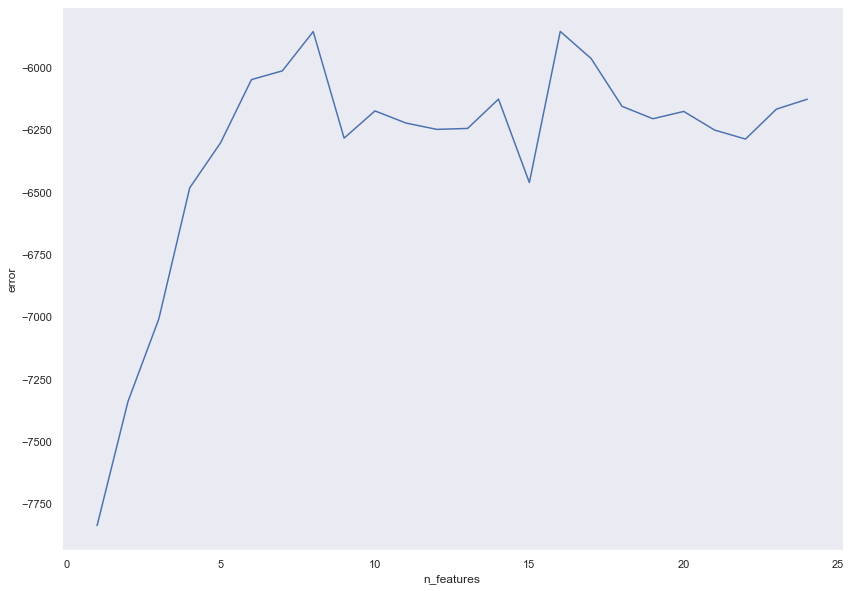

In [106]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

## Select Optimal Features

In [107]:
top_n = 30
# optimal_n_features = min(rfe.grid_scores_.argmax() + 1, top_n)
optimal_n_features = rfe.grid_scores_.argmax() + 1

In [108]:
print(f'The optimal number of features is: {optimal_n_features}')

The optimal number of features is: 16


In [109]:
feature_ranking = pd.Series(rfe.ranking_, index=x_cols)

In [110]:
feature_ranking.sort_values()

primary_size              1
furniture_store           1
food                      1
finance                   1
establishment             1
school                    1
point_of_interest         1
restaurant                1
post_code_place_count     1
med_price_house           1
med_price_apartment       1
construction_year         1
num_bedrooms              1
floor                     1
time_s                    1
home_goods_store          1
mean_post_code_rating     2
hair_care                 3
store                     4
car_repair                5
clothing_store            6
grocery_or_supermarket    7
health                    8
electronics_store         9
dtype: int64

In [111]:
selected_features = list(feature_ranking.sort_values()[:optimal_n_features].index)

In [112]:
selected_features

['primary_size',
 'furniture_store',
 'food',
 'finance',
 'establishment',
 'school',
 'point_of_interest',
 'restaurant',
 'post_code_place_count',
 'med_price_house',
 'med_price_apartment',
 'construction_year',
 'num_bedrooms',
 'floor',
 'time_s',
 'home_goods_store']

# Fit Model

In [113]:
pipeline.fit(X_train[selected_features], y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [114]:
pred = pipeline.predict(X_test[selected_features])

In [115]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

# Draw Learning Curves

In [116]:
learning_curve_res = get_learning_curves(pipeline, X_train[selected_features], y_train, score='neg_median_absolute_error')

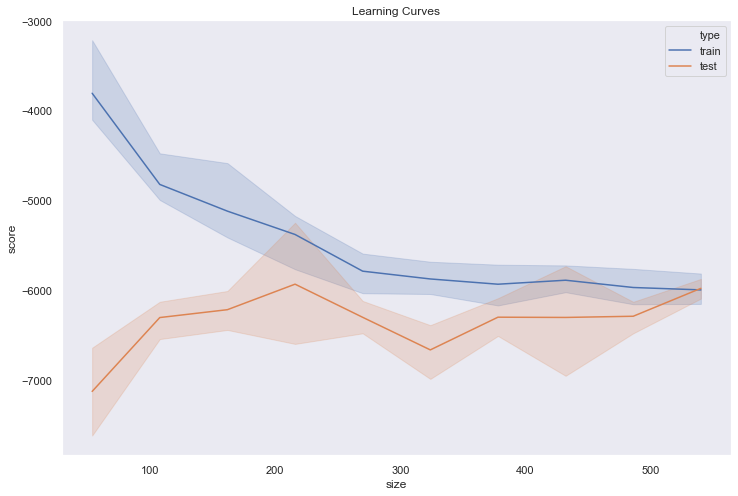

In [117]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [118]:
cv_res = get_cv_res(pipeline,
                    X_train[selected_features],
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [119]:
print_cv_res(cv_res)

Mean fit_time, 0.08
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -6107.86
Mean test_r2, 0.65
Mean test_explained_variance, 0.67
Mean test_max_error, -47882.49


## Display Predicted VS Actual

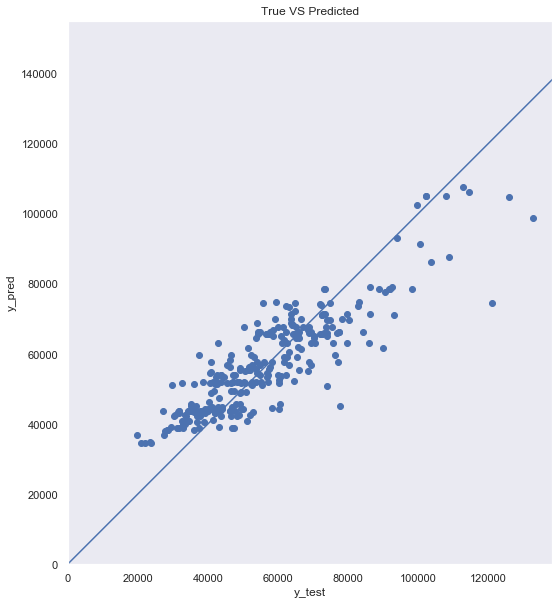

In [120]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

## Display Error Spread

In [121]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot[target]

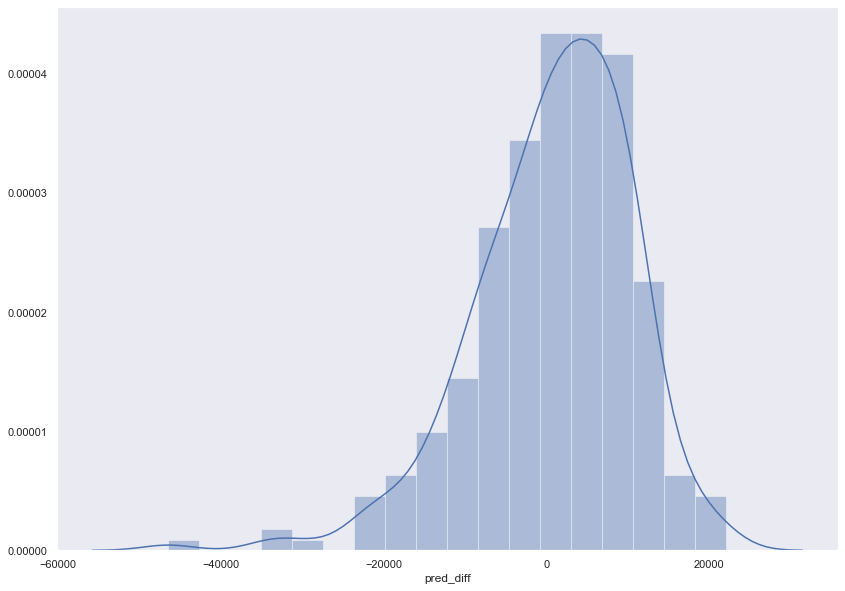

In [122]:
sns.distplot(to_plot.pred_diff)

### Top Overvalued

In [123]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).head()

,,primary_size,time_s,floor,num_bedrooms,construction_year,med_price_apartment,med_price_house,mean_post_code_rating,post_code_place_count,car_repair,clothing_store,electronics_store,establishment,finance,food,furniture_store,grocery_or_supermarket,hair_care,health,home_goods_store,point_of_interest,restaurant,school,store,predicted,price_per_sq_m,pred_diff
ad_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
150041920,4813,56.0,3573.0,2.0,1.0,2005.0,44158.0,52838.0,4.250,10.0,0.0,0.0,0.0,11.0,0.0,4.0,0.0,0.0,1.0,4.0,0.0,11.0,3.0,0.0,1.0,59588.262295,37452.0,22136.262295
149949428,4777,273.0,2554.0,2.0,3.0,1963.0,75455.0,53537.5,5.000,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,51106.464646,29701.0,21405.464646
151098033,5249,65.0,2259.0,1.0,2.0,1958.0,71522.0,40508.0,4.525,12.0,0.0,0.0,0.0,13.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,13.0,0.0,0.0,1.0,63221.124629,42881.0,20340.124629
151527397,5392,69.0,4552.0,2.0,1.0,1971.0,43206.0,37255.0,4.160,10.0,0.0,0.0,0.0,11.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,11.0,0.0,0.0,2.0,51801.202381,32694.0,19107.202381
149515013,4343,73.0,1495.0,1.0,2.0,1957.0,79991.5,71031.0,4.500,2.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,8.0,2.0,0.0,1.0,74560.490964,55878.0,18682.490964


### Top Undervalued

In [124]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).tail()

primary_size   time_s  floor  num_bedrooms  construction_year  \
ad_id                                                                           
147931548 3821         115.0  15199.0    5.0           3.0             2019.0   
          3829          44.0  15199.0    7.0           1.0             2019.0   
150596184 5040         119.0   5065.0    2.0           2.0             1917.0   
149581606 4429          85.0   2219.0    4.0           2.0             2017.0   
106352673 605           82.0   1521.0    4.0           2.0             2019.0   

                med_price_apartment  med_price_house  mean_post_code_rating  \
ad_id                                                                         
147931548 3821              76734.0          50236.5             4.160000     
          3829              76734.0          50236.5             4.160000     
150596184 5040              56876.0          67407.0             4.480000     
149581606 4429             113015.5          93957.0             4.542857     
106352673 605               72596.0          46875.5             3.285714     

                post_code_place_count  car_repair  clothing_store  \
ad_id                                                               
147931548 3821                 15.0           0.0             1.0   
          3829                 15.0           0.0             1.0   
150596184 5040                  5.0           0.0             0.0   
149581606 4429                  7.0           0.0             1.0   
106352673 605                   7.0           0.0             0.0   

                electronics_store  establishment  finance  food  \
ad_id                                                             
147931548 3821                3.0           16.0      0.0   0.0   
          3829                3.0           16.0      0.0   0.0   
150596184 5040                0.0            5.0      0.0   0.0   
149581606 4429                0.0           10.0      0.0   1.0   
106352673 605                 0.0            7.0      0.0   0.0   

                furniture_store  grocery_or_supermarket  hair_care  health  \
ad_id                                                                        
147931548 3821              0.0                  0.0           0.0     3.0   
          3829              0.0                  0.0           0.0     3.0   
150596184 5040              0.0                  0.0           0.0     0.0   
149581606 4429              1.0                  1.0           0.0     4.0   
106352673 605               0.0                  0.0           0.0     0.0   

                home_goods_store  point_of_interest  restaurant  school  \
ad_id                                                                     
147931548 3821               3.0               16.0         0.0     0.0   
          3829               3.0               16.0         0.0     0.0   
150596184 5040               1.0                5.0         0.0     0.0   
149581606 4429               1.0               10.0         0.0     0.0   
106352673 605                1.0                7.0         0.0     0.0   

                store     predicted  price_per_sq_m     pred_diff  
ad_id                                                              
147931548 3821    6.0  50901.159420         73970.0 -23068.840580  
          3829    6.0  61676.981132         89920.0 -28243.018868  
150596184 5040    1.0  45031.618557         77648.0 -32616.381443  
149581606 4429    3.0  98793.000000        132746.0 -33953.000000  
106352673 605     1.0  74560.490964        120991.0 -46430.509036

# Display Feature Importances

In [125]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=selected_features).sort_values(ascending=True)

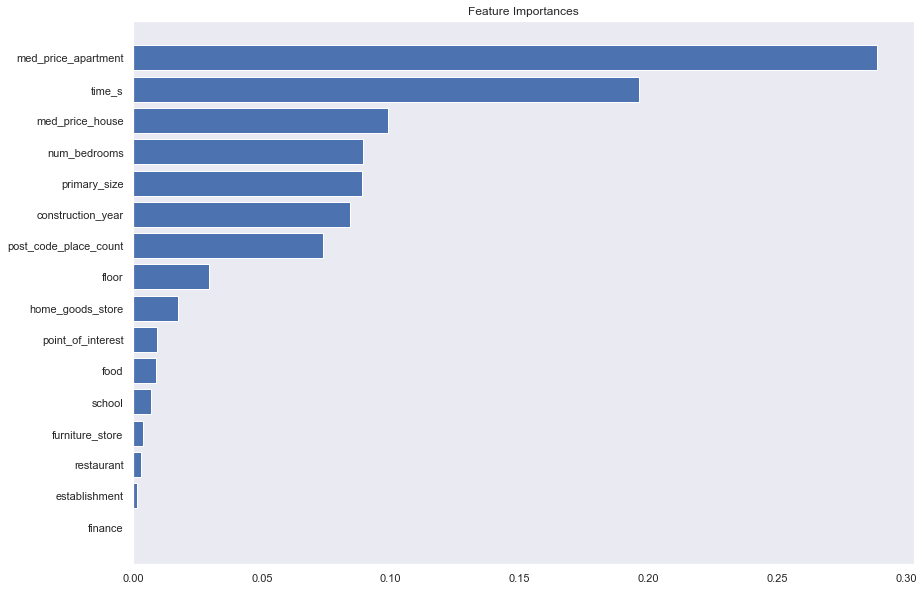

In [126]:
top_n = 30
to_plot = feature_importances[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With NLP

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [128]:
selected_text_char = 'full_description'

In [129]:
text_data = text_data[text_data.index.isin(model_data.index)].join(model_data[target])

In [130]:
text_data.head()

full_description  price_per_sq_m
ad_id                                           
69757913 11  FremdriftSnr 34,...         39991.0
         9   FremdriftSnr 34,...         39429.0
         0   FremdriftSnr 34,...         36086.0
78653360 14  Om ProsjektetI S...         71210.0
         17  Om ProsjektetI S...         64966.0

In [131]:
def tokenize_regex(regex, text):
    return [t.lower() for t in re.split(regex, text) if t != '']

In [132]:
def recognize_num(text):
    modified = []
    for t in text:
        try:
            num = int(t)
            modified.append('<num>')
        except ValueError as e:
            modified.append(t)
    return modified

In [133]:
punct_whitesp = re.compile(r'\s|[\+\-\.\,\(\)\?\!]+')

In [134]:
text_data[f'{selected_text_char}_split'] = [tokenize_regex(punct_whitesp, t) for t in text_data[selected_text_char]]
text_data[f'{selected_text_char}_split'] = [recognize_num(text) for text in text_data[f'{selected_text_char}_split']]

In [135]:
text_data.head()

full_description  price_per_sq_m full_description_split
ad_id                                                                  
69757913 11  FremdriftSnr 34,...         39991.0  [fremdriftsnr, <...  
         9   FremdriftSnr 34,...         39429.0  [fremdriftsnr, <...  
         0   FremdriftSnr 34,...         36086.0  [fremdriftsnr, <...  
78653360 14  Om ProsjektetI S...         71210.0  [om, prosjekteti...  
         17  Om ProsjektetI S...         64966.0  [om, prosjekteti...

In [136]:
def dummy_tokenizer(doc):
    return doc

In [137]:
count_vectorizer = CountVectorizer(analyzer='word',
                                   tokenizer=dummy_tokenizer,
                                   preprocessor=dummy_tokenizer,
                                   ngram_range=(1, 1),
                                   token_pattern=None,
                                   min_df=2)

In [138]:
vectorized_full_desc = count_vectorizer.fit_transform(text_data[f'{selected_text_char}_split'])

In [139]:
y_text = text_data.price_per_sq_m

In [140]:
term_index = pd.Series(count_vectorizer.vocabulary_)

In [141]:
term_frequency = pd.Series(vectorized_full_desc.toarray().sum(axis=0), index=term_index.sort_values(ascending=True).index)

In [142]:
stop_word_min_rank = 80

In [143]:
stop_words = list(term_frequency.sort_values(ascending=False)[:stop_word_min_rank].index)

In [144]:
def remove_stop_words(stop_word_list, text):
    return list(set(text) - set(stop_word_list))

In [145]:
text_data[f'{selected_text_char}_split'] = [remove_stop_words(stop_words, text) for text in text_data[f'{selected_text_char}_split']]

In [146]:
vectorized_full_desc = count_vectorizer.fit_transform(text_data[f'{selected_text_char}_split'])

In [147]:
tfidf_transformer = TfidfTransformer()

In [148]:
tfidf = tfidf_transformer.fit_transform(vectorized_full_desc)

In [149]:
tfidf

<966x14747 sparse matrix of type '<class 'numpy.float64'>'
	with 242255 stored elements in Compressed Sparse Row format>

In [150]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(tfidf,
                                                                        y_text,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [151]:
estimator.fit(X_text_train, y_text_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [152]:
y_text_pred = estimator.predict(X_text_test)

# Draw Learning Curves

In [153]:
learning_curve_res = get_learning_curves(estimator,
                                         X_text_train,
                                         y_text_train,
                                         score='neg_median_absolute_error')

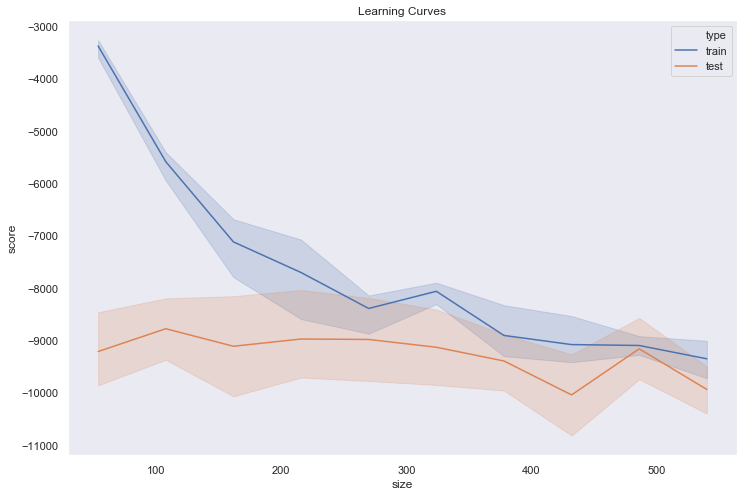

In [154]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [155]:
cv_res = get_cv_res(estimator,
                    X_text_train,
                    y_text_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [156]:
print_cv_res(cv_res)

Mean fit_time, 1.36
Mean score_time, 0.06
Mean test_neg_median_absolute_error, -9939.99
Mean test_r2, 0.32
Mean test_explained_variance, 0.33
Mean test_max_error, -52506.82


In [157]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

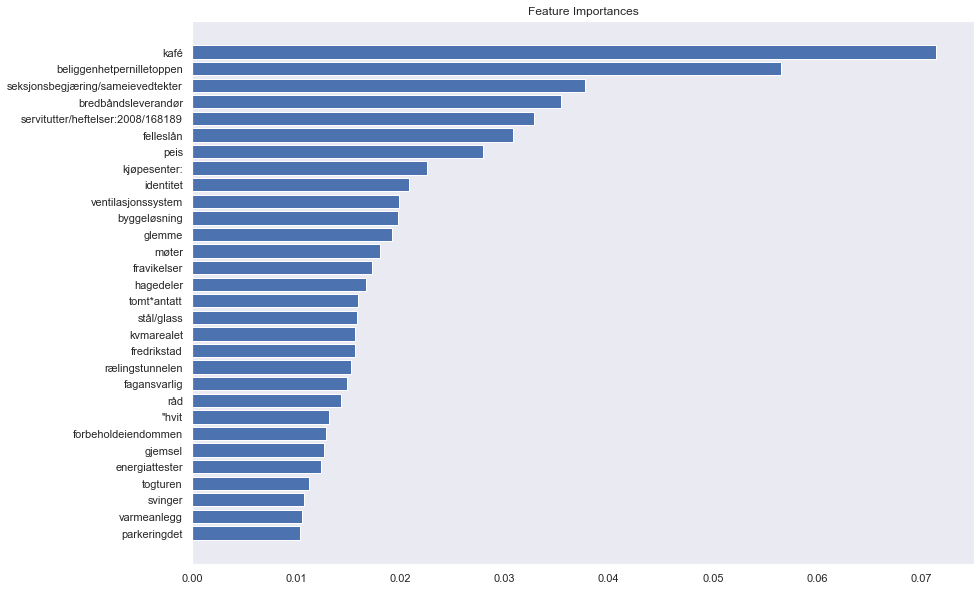

In [158]:
top_n = 30
to_plot = feature_importances.sort_values(ascending=True)[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [159]:
top_n = 10
best_text_features = list(feature_importances.sort_values(ascending=False)[:top_n].index)

In [160]:
best_text_features

['kafé',
 'beliggenhetpernilletoppen',
 'seksjonsbegjæring/sameievedtekter',
 'bredbåndsleverandør',
 'servitutter/heftelser:2008/168189',
 'felleslån',
 'peis',
 'kjøpesenter:',
 'identitet',
 'ventilasjonssystem']

In [161]:
all_features = X

In [162]:
for f in best_text_features:
    all_features[f] = text_data[selected_text_char].str.lower().str.contains(f).map({True: 1, False: 0})

# Predict Price With All Features

In [163]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(all_features,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [164]:
pipeline.fit(X_full_train, y_full_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [165]:
y_pred = estimator.predict(X_full_test)

# Draw Learning Curves

In [166]:
learning_curve_res = get_learning_curves(pipeline,
                                         X_full_train,
                                         y_full_train,
                                         score='neg_median_absolute_error')

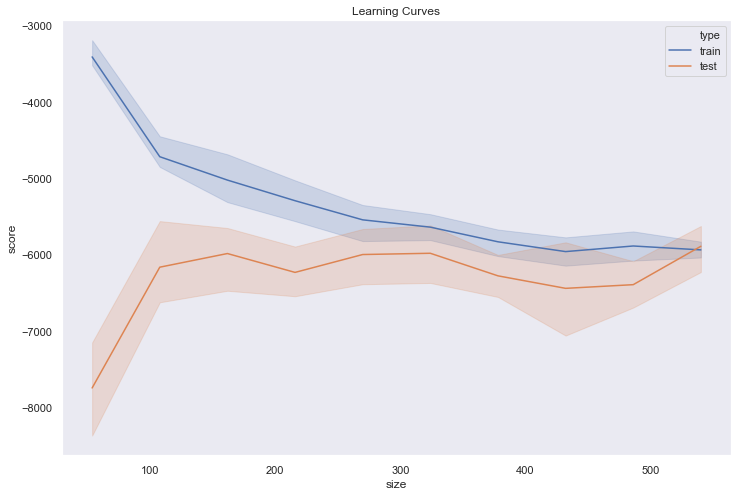

In [167]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [168]:
cv_res = get_cv_res(pipeline,
                    X_full_train,
                    y_full_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [169]:
print_cv_res(cv_res)

Mean fit_time, 0.09
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -5782.58
Mean test_r2, 0.65
Mean test_explained_variance, 0.67
Mean test_max_error, -38901.57


# Display Feature Importances

In [170]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=X.columns).sort_values(ascending=True)

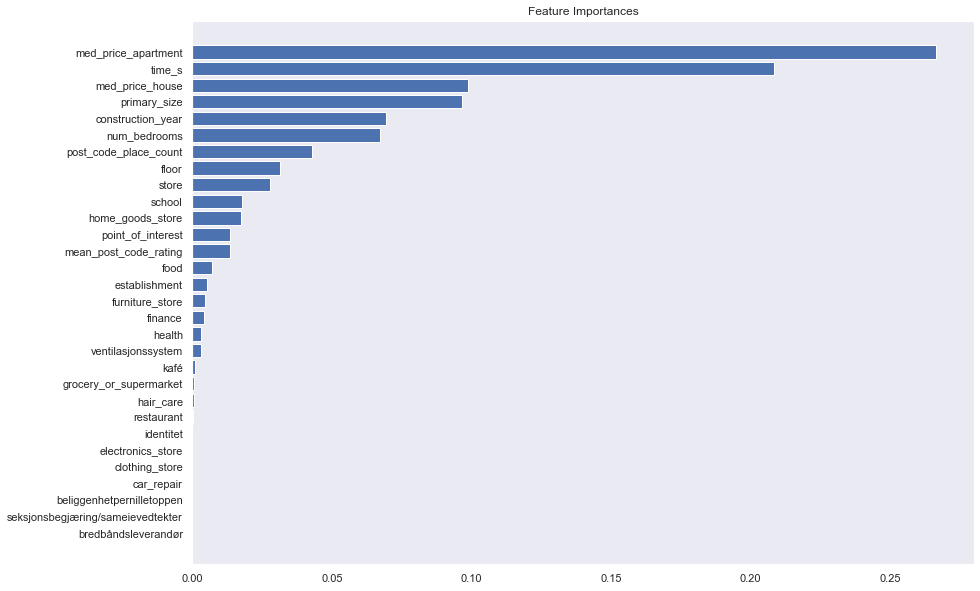

In [171]:
top_n = 30
to_plot = feature_importances[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# TODO
* Draw learning curves on multiple metrics
* Produce statistics for all types of models
* Select final model
* Tune up the final model
* Deploy model to cloud